In [48]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-2 region. You will use the 825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [4]:
%matplotlib inline

In [5]:
#Creating s3 bucket to store data
bucket_name = 'cred-card-fraud-s3-bucket' #no capital letters
#boto3 is AWS SDK (software development kit) for python
#Creates an s3 resource service client
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)


S3 error:  An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [8]:
#Loading credit card data from github
try:
  urllib.request.urlretrieve ("https://raw.githubusercontent.com/jbrownlee/Datasets/master/creditcard.csv.zip", "creditcard.csv.zip")
  print('Success: downloaded creditcard.csv.zip.')
  #Now unzipping credit card data
  try:
        !unzip creditcard.csv.zip
  except Exception as e:
        print('Failed to unzip: ',e)
except Exception as e:
  print('Failed to download data: ',e)


Success: downloaded creditcard.csv.zip.
Archive:  creditcard.csv.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [9]:
!ls

creditcard.csv	    CreditCardFraud.ipynb    lost+found  README.md
creditcard.csv.zip  creditcard_reformat.csv  __MACOSX


In [8]:
#Unzipping credit card
!unzip creditcard.csv.zip

Archive:  creditcard.csv.zip
  inflating: creditcard.csv          
   creating: __MACOSX/
  inflating: __MACOSX/._creditcard.csv  


In [11]:
#Adding columns
v_columns = ['v' + str(i) for i in np.arange(1,29)]
columns = ['Time'] + v_columns +['Amount','Class']
columns

['Time',
 'v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9',
 'v10',
 'v11',
 'v12',
 'v13',
 'v14',
 'v15',
 'v16',
 'v17',
 'v18',
 'v19',
 'v20',
 'v21',
 'v22',
 'v23',
 'v24',
 'v25',
 'v26',
 'v27',
 'v28',
 'Amount',
 'Class']

In [12]:
#Load in to dataframe 
try:
  cc_df = pd.read_csv('./creditcard.csv', names = columns)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Failed to import data in to dataframe: ',e)


Success: Data loaded into dataframe.


In [44]:
#Exploring data
cc_df.head()

,Time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [45]:
cc_df.describe()

,Time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [58]:
#Investigating skewedness
for col in cc_df.columns:
    print(f'col:{col} mean:{cc_df[col].mean()} median: {cc_df[col].median()})# mode: {cc_df[col].mode()}')
#     print(cc_df[col].mean())
#Some serious skewedness going on here

col:Time mean:94813.85957508067 median: 84692.0)# mode: 0    163152.0
dtype: float64
col:v1 mean:3.919560084655042e-15 median: 0.0181087991615309)# mode: 0    1.245674
1    2.055797
dtype: float64
col:v2 mean:5.688174400270728e-16 median: 0.0654855563960555)# mode: 0   -0.326668
1    0.166975
dtype: float64
col:v3 mean:-8.76907126289773e-15 median: 0.17984634356354398)# mode: 0   -2.752041
1    0.488306
dtype: float64
col:v4 mean:2.782312291808533e-15 median: -0.0198465294811989)# mode: 0   -0.842316
1    0.635322
dtype: float64
col:v5 mean:-1.5525630329923732e-15 median: -0.0543358267364858)# mode: 0   -0.562777
1    2.463072
dtype: float64
col:v6 mean:2.010663493875542e-15 median: -0.27418707650665103)# mode: 0   -1.011073
1    3.173856
dtype: float64
col:v7 mean:-1.694249132734738e-15 median: 0.0401030827945351)# mode: 0   -0.432126
1    0.014953
dtype: float64
col:v8 mean:-1.9270277088072758e-16 median: 0.0223580364366631)# mode: 0   -0.160211
1    0.727706
dtype: float64
col:v9 me

284807

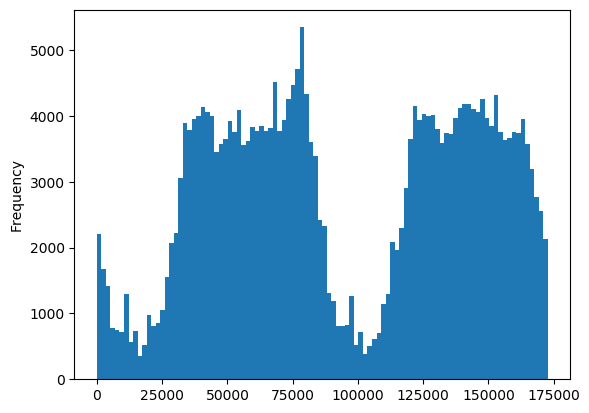

In [62]:
cc_df['Time'].plot.hist(bins=100)
len(cc_df['Time'])


284807

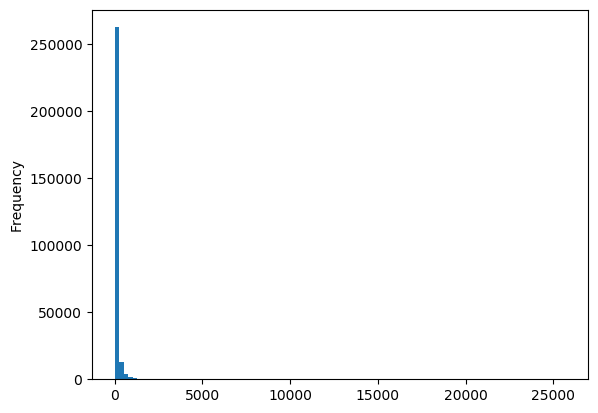

In [63]:
cc_df['Amount'].plot.hist(bins=100)
len(cc_df['Amount'])

284807

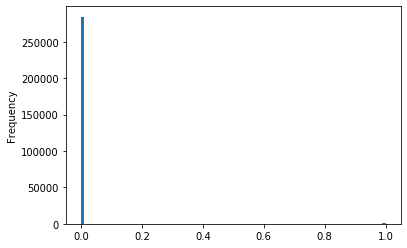

In [13]:
cc_df['Class'].plot.hist(bins=100)
len(cc_df['Class'])


In [19]:
#Finding how many of each have been labelled as fraud and non-fraud
cc_df['Class'].value_counts(1)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [18]:
#Checking for empty values
cc_df.all().notnull()

Time      True
v1        True
v2        True
v3        True
v4        True
v5        True
v6        True
v7        True
v8        True
v9        True
v10       True
v11       True
v12       True
v13       True
v14       True
v15       True
v16       True
v17       True
v18       True
v19       True
v20       True
v21       True
v22       True
v23       True
v24       True
v25       True
v26       True
v27       True
v28       True
Amount    True
Class     True
dtype: bool

In [20]:
#Random undersampling
#Saving copy
cc_df_copy = cc_df


In [27]:
print(cc_df[cc_df['Class'] == 0].head())
print(len(cc_df[cc_df['Class'] == 0]))
print((cc_df['Class'] == 1).sum())

   Time        v1        v2        v3        v4        v5        v6        v7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         v8        v9  ...       v21       v22       v23       v24       v25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        v26       v27       v28 

In [32]:
#Undersampling the non-fradulent transactions
cc_df_undersamp = cc_df[cc_df['Class'] == 0].sample(n = (cc_df['Class'] == 1).sum(), random_state = 42)

In [45]:
cc_df_undersamp = pd.concat([cc_df_undersamp,cc_df[cc_df['Class'] == 1]])

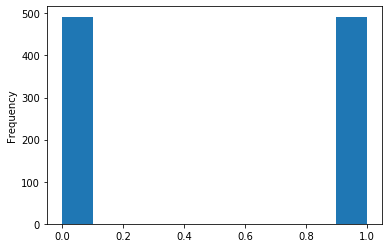

In [46]:
cc_df_undersamp['Class'].plot.hist()

In [49]:
#Making pipeline
prep_pipeline = Pipeline([
    ('std scaler', StandardScaler())
])

In [57]:
#Using pipeline, adding data back in to dataframe
prep_pipeline.fit(cc_df_undersamp)
cc_df_undersamp.update(prep_pipeline.transform(cc_df_undersamp))


In [59]:
cc_df_undersamp.head()

,Time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,Amount,Class
138028,82450.0,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,...,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0.76,0
63099,50554.0,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,...,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,4.18,0
73411,55125.0,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,...,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,15.00,0
164247,116572.0,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,...,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,57.00,0
148999,90434.0,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,...,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0.00,0


In [30]:
#Going to skip normalizing, removing outliers, and oversampling for a moment

In [63]:
cc_df_undersamp = cc_df_undersamp.reindex()
cc_df_undersamp = cc_df_undersamp.sort_index()

In [66]:
cc_df_undersamp.reset_index().drop(columns = ['index'])

,Time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,607.0,1.038261,-0.301415,0.910167,0.863872,-0.741702,0.090125,-0.409753,0.076723,0.684990,...,0.134996,0.554309,-0.138944,0.168500,0.423859,0.530611,0.014980,0.028041,69.99,0
3,861.0,-0.945987,1.232753,0.820313,0.311064,0.981736,0.935188,0.566926,-0.008604,-0.621912,...,0.124922,0.284644,-0.197951,-1.326061,-0.161715,-0.382919,-0.488500,0.144470,10.00,0
4,1308.0,-1.379848,0.536720,2.647870,1.408111,0.126442,0.986525,0.960251,-0.629717,1.729173,...,-0.666874,-0.343574,0.022138,0.093532,0.011293,-0.503395,-0.438189,-0.346731,43.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1
980,170348.0,1.991976,0.158476,-2.583441,0.408670,1.151147,-0.096695,0.223050,-0.068384,0.577829,...,-0.164350,-0.295135,-0.072173,-0.450261,0.313267,-0.289617,0.002988,-0.015309,42.53,1
981,170846.0,2.237256,-1.277067,-0.508643,-1.243620,-1.813798,-1.616728,-0.961207,-0.372181,-1.295114,...,-0.110137,0.210433,0.340176,0.914126,-0.287532,-0.218192,0.010060,-0.042277,15.00,0
982,171621.0,-10.979719,9.441250,-7.679816,-3.091572,-2.606832,-1.688433,-1.565577,3.600139,5.232322,...,-0.689142,0.222755,0.493056,0.094231,1.497581,-0.029859,0.657312,-0.707135,1.46,0


In [67]:
len(cc_df_undersamp)
#Splitting in to test and training data
mask = np.random.rand(len(cc_df_undersamp)) < 0.8
train_data = cc_df_undersamp[mask]
test_data = cc_df_undersamp[~mask]
print(np.shape(train_data))
print(np.shape(test_data))

# train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(cc_df))])
# print(train_data.shape, test_data.shape)

(776, 31)
(208, 31)


In [70]:
#Moves label to first column, so is formatted correctly for xgboost
pd.concat([cc_df_undersamp['Class'], cc_df_undersamp.drop(['Class'], axis=1)], axis=1).reset_index().drop(columns = ['index'])

,Class,Time,v1,v2,v3,v4,v5,v6,v7,v8,...,v20,v21,v22,v23,v24,v25,v26,v27,v28,Amount
0,1,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00
1,1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00
2,0,607.0,1.038261,-0.301415,0.910167,0.863872,-0.741702,0.090125,-0.409753,0.076723,...,0.040056,0.134996,0.554309,-0.138944,0.168500,0.423859,0.530611,0.014980,0.028041,69.99
3,0,861.0,-0.945987,1.232753,0.820313,0.311064,0.981736,0.935188,0.566926,-0.008604,...,-0.044043,0.124922,0.284644,-0.197951,-1.326061,-0.161715,-0.382919,-0.488500,0.144470,10.00
4,0,1308.0,-1.379848,0.536720,2.647870,1.408111,0.126442,0.986525,0.960251,-0.629717,...,0.464675,-0.666874,-0.343574,0.022138,0.093532,0.011293,-0.503395,-0.438189,-0.346731,43.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,1,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,...,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00
980,1,170348.0,1.991976,0.158476,-2.583441,0.408670,1.151147,-0.096695,0.223050,-0.068384,...,-0.017652,-0.164350,-0.295135,-0.072173,-0.450261,0.313267,-0.289617,0.002988,-0.015309,42.53
981,0,170846.0,2.237256,-1.277067,-0.508643,-1.243620,-1.813798,-1.616728,-0.961207,-0.372181,...,-0.477371,-0.110137,0.210433,0.340176,0.914126,-0.287532,-0.218192,0.010060,-0.042277,15.00
982,0,171621.0,-10.979719,9.441250,-7.679816,-3.091572,-2.606832,-1.688433,-1.565577,3.600139,...,3.660069,-0.689142,0.222755,0.493056,0.094231,1.497581,-0.029859,0.657312,-0.707135,1.46


In [132]:
pd.concat([cc_df['Class'], cc_df.drop(['Class'], axis=1)], axis=1)

,Class,Time,v1,v2,v3,v4,v5,v6,v7,v8,...,v20,v21,v22,v23,v24,v25,v26,v27,v28,Amount
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,0,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,0,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,0,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,0,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,0,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [72]:
#Training the model
#Need to reformat the header and first column
# pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1)#.to_csv('train.csv', index=False, header=False)

pd.concat([cc_df['Class'], cc_df.drop(['Class'], axis=1)], axis=1).reset_index().drop(columns = ['index']).to_csv('creditcard_reformat.csv', index=False, header=False)

In [73]:
#Uploading reformatted data to s3 bucket
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/creditcard_reformat.csv')).upload_file('creditcard_reformat.csv')


In [74]:
#Setting up input train for model
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')


In [75]:
#Session object manages interaction with Sagemaker and other AWS services
sess = sagemaker.Session()

In [76]:
#Making instance of XGBoost model
xgb = sagemaker.estimator.Estimator(containers[my_region],role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)


In [77]:
#Setting hyperparameters of model
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)


In [78]:
#Fitting the model, using the input train
xgb.fit({'train': s3_input_train})

2021-01-04 16:52:35 Starting - Starting the training job...
2021-01-04 16:52:59 Starting - Launching requested ML instancesProfilerReport-1609779154: InProgress
......
2021-01-04 16:53:59 Starting - Preparing the instances for training......
2021-01-04 16:55:00 Downloading - Downloading input data...
2021-01-04 16:55:32 Training - Training image download completed. Training in progress..Arguments: train
[2021-01-04:16:55:33:INFO] Running standalone xgboost training.
[2021-01-04:16:55:33:INFO] Path /opt/ml/input/data/validation does not exist!
[2021-01-04:16:55:33:INFO] File size need to be processed in the node: 148.64mb. Available memory size in the node: 8419.61mb
[2021-01-04:16:55:33:INFO] Determined delimiter of CSV input is ','
[16:55:33] S3DistributionType set as FullyReplicated
[16:55:34] 284807x30 matrix with 8544210 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[16:55:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nod

[16:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=5
[51]#011train-error:0.000309
[16:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[52]#011train-error:0.000309
[16:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=5
[53]#011train-error:0.000302
[16:56:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=5
[54]#011train-error:0.000312
[16:56:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[55]#011train-error:0.000309
[16:56:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=5
[56]#011train-error:0.000298
[16:56:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=5
[57]#011train-error:0.000302
[16:56:04] sr

In [ ]:
#Deploying model
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')


-------

In [136]:
#Preparing data to test the model
test_data = test_data.drop(['index'], axis=1)
test_data

,Time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,Amount,Class
0,12.0,-2.791855,-0.327771,1.641750,1.767473,-0.136588,0.807596,-0.422911,-1.907107,0.755713,...,1.151663,0.222182,1.020586,0.028317,-0.232746,-0.235557,-0.164778,-0.030154,58.80,0
1,12.0,1.103215,-0.040296,1.267332,1.289091,-0.735997,0.288069,-0.586057,0.189380,0.782333,...,-0.024612,0.196002,0.013802,0.103758,0.364298,-0.382261,0.092809,0.037051,12.99,0
2,15.0,1.492936,-1.029346,0.454795,-1.438026,-1.555434,-0.720961,-1.080664,-0.053127,-1.978682,...,-0.177650,-0.175074,0.040002,0.295814,0.332931,-0.220385,0.022298,0.007602,5.00,0
3,17.0,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,0.143997,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,34.09,0
4,23.0,1.173285,0.353498,0.283905,1.133563,-0.172577,-0.916054,0.369025,-0.327260,-0.246651,...,0.067003,0.227812,-0.150487,0.435045,0.724825,-0.337082,0.016368,0.030041,41.88,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57032,172780.0,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,60.00,0
57033,172782.0,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,24.05,0
57034,172784.0,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,...,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,2.68,0
57035,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0


In [123]:
!pip install --upgrade sagemaker

     |████████████████████████████████| 396 kB 6.2 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.22.0-py2.py3-none-any.whl size=559175 sha256=9f8beeba5703a2b2f5c82dceef34eea603b90ff632c88f68b9877743981e9208
  Stored in directory: /home/ec2-user/.cache/pip/wheels/87/82/d3/4c49c2c917f1e2c47537f4e3690753c9847e1ca3da951fba00
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.19.0
    Uninstalling sagemaker-2.19.0:
      Successfully uninstalled sagemaker-2.19.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [140]:
#load the data into an array, removing the labels
test_data_array = test_data[:10000].drop(['Class'], axis=1).values 
test_data_array.shape
# xgb_predictor.content_type = 'text/csv' # set the data type for an inference
#sagemaker.predictor.csv_serializer is now sagemaker.serializers.CSVSerializer()
#set the serializer type for a csv file
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer() 
# predict using the model
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') 
# and turn the prediction into an array
predictions_array = np.fromstring(predictions[1:], sep=',') 
print(predictions_array.shape)


(10000,)


In [1]:
#Setting up confusion matrix
con_mat = pd.crosstab(index=test_data[:10000]['Class'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])

true_neg = con_mat.iloc[0,0]; false_neg = con_mat.iloc[1,0]; true_pos = con_mat.iloc[1,1]; false_pos = con_mat.iloc[0,1]; p = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Fraud Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Fraud", "Fraud"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Fraud", true_neg/(true_neg+false_neg)*100,true_neg, false_pos/(true_pos+false_pos)*100, false_pos))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Fraud", false_neg/(true_neg+false_neg)*100,false_neg, true_pos/(true_pos+false_pos)*100, true_pos))


NameError: name 'pd' is not defined

In [148]:
#Deleting resources used so don't get charged
# the endpoint attribute has been renamed to endpoint_name
#sagemaker.Session().delete_endpoint(xgb_predictor.endpoint_name)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()


[]

In [149]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint_name)

ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-2:190626435342:endpoint/xgboost-2020-12-23-11-29-18-020".

In [150]:
!pwd

/home/ec2-user/SageMaker
